In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

import gymnasium as gym


In [2]:
from algorithms.reinforce import ReinforceAgent
from algorithms.dqn import DQNAgent
from networks.policy import DiscretePolicy, ContinuousPolicy
from networks.value_networks import Qnet
from utils.eval_utils import *

# REINFORCE

Evaluate ReinforceAgent on Classic Control Environments

### Acrobot

In [10]:
ENV_NAME = 'Acrobot-v1'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0])
)

reinforce_agent = ReinforceAgent(policy, policy_lr=.3, optimiser=optim.SGD)

reinforce_agent.train('Acrobot-v1', num_iters=50, batch_size=10, eval_freq=5)

evaluating at 0
evaluating at 50
evaluating at 100
evaluating at 150
evaluating at 200
evaluating at 250
evaluating at 300
evaluating at 350
evaluating at 400
evaluating at 450


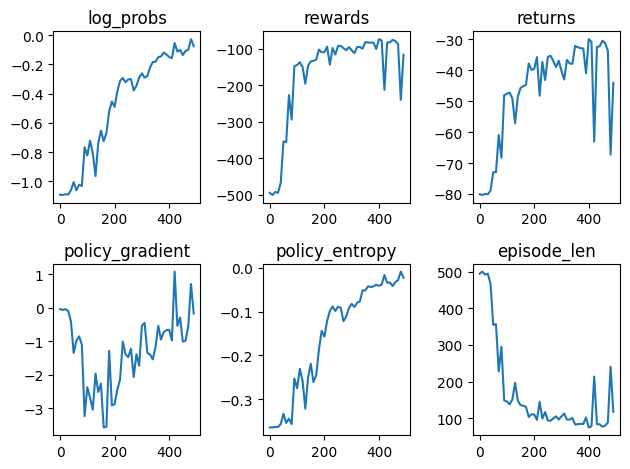

In [11]:
plot_training_results(reinforce_agent.batch_results)

In [3]:
ENV_NAME = 'Acrobot-v1'
env = gym.make(ENV_NAME)

q_net = Qnet(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0]),
    2
)

dqn_agent = DQNAgent(q_net, 
        lr=1.0e-4, 
        optimiser=optim.AdamW,
        buffer_size=10000,
        mini_batch_size=128,
        epsilon=.9,
        discount_rate=.99)

dqn_agent.train(ENV_NAME, num_episodes=500,eval_freq=50)

c:\Users\61417\Documents\misc_projects\spinning_up_rl\networks\value_networks.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


evaluating at 0...
evaluating at 50...
evaluating at 100...
evaluating at 150...
evaluating at 200...
evaluating at 250...
evaluating at 300...
evaluating at 350...
evaluating at 400...
evaluating at 450...


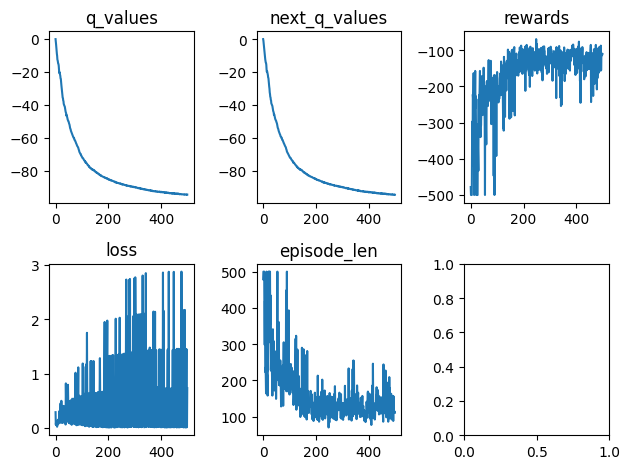

In [6]:
plot_training_results(dqn_agent.batch_results)

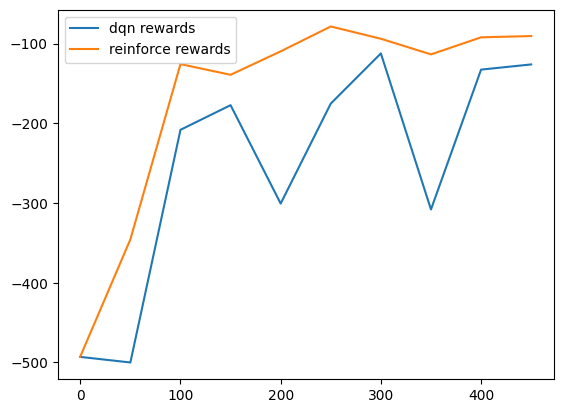

In [12]:
plt.plot(
    dqn_agent.eval_results.keys(),
    dqn_agent.eval_results.values(),
    label='dqn rewards'
)

plt.plot(
    reinforce_agent.eval_results.keys(),
    reinforce_agent.eval_results.values(),
    label='reinforce rewards'
)

plt.legend()
plt.show();

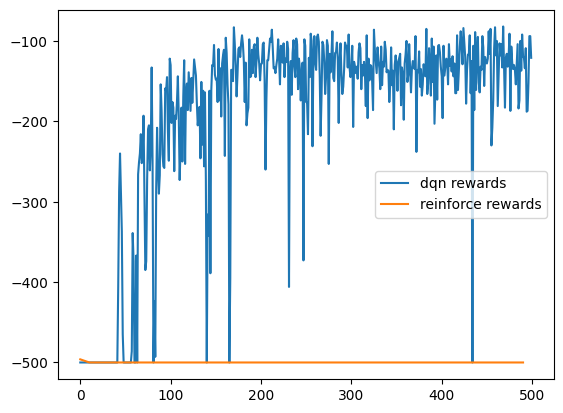

In [15]:
reinforce_rewards = [reinforce_agent.batch_results[i]['rewards'] for i in reinforce_agent.batch_results.keys()]
dqn_rewards = [dqn_agent.batch_results[i]['rewards'] for i in dqn_agent.batch_results.keys()]

plt.plot(list(dqn_agent.batch_results.keys()), dqn_rewards, label='dqn rewards')
plt.plot(list(reinforce_agent.batch_results.keys()), reinforce_rewards, label='reinforce rewards')
plt.legend()
plt.show();

### CartPole

In [5]:
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

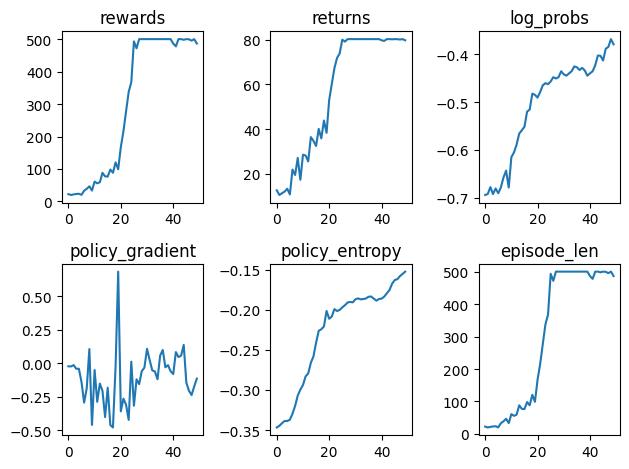

In [6]:
plot_training_results(agent.batch_results)

In [32]:
rewards = eval_agent(agent, env, 10)
print(rewards)

{0: 444.0, 1: 156.0, 2: 356.0, 3: 256.0, 4: 364.0, 5: 500.0, 6: 423.0, 7: 500.0, 8: 363.0, 9: 423.0}


### Mountain Car

In [7]:
ENV_NAME = 'MountainCar-v0'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    1*(env.action_space.n+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

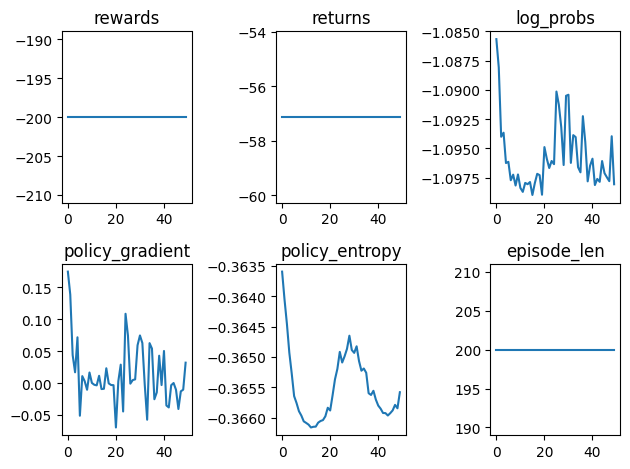

In [8]:
plot_training_results(agent.batch_results)

In [35]:
rewards = eval_agent(agent, env, 10)
print(rewards)

{0: -200.0, 1: -200.0, 2: -200.0, 3: -200.0, 4: -200.0, 5: -200.0, 6: -200.0, 7: -200.0, 8: -200.0, 9: -200.0}


### Mountain Car Continuous

In [9]:
ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

policy = ContinuousPolicy(
    env.observation_space.shape[0], 
    env.action_space.shape[0], 
    2*(env.action_space.shape[0]+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

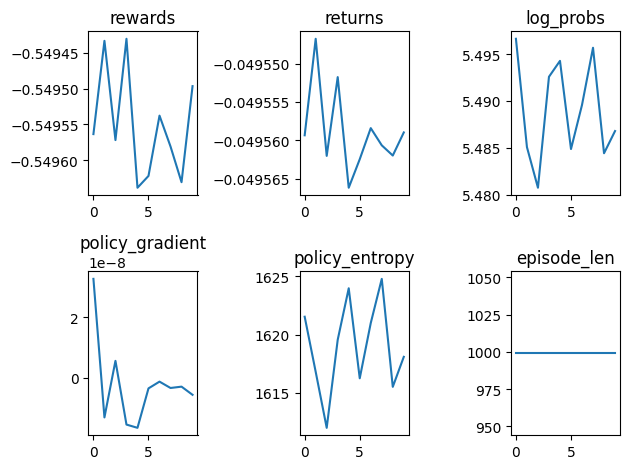

In [14]:
plot_training_results(agent.batch_results)

### Pendulum

In [18]:
ENV_NAME = 'Pendulum-v1'
env = gym.make(ENV_NAME)

policy = ContinuousPolicy(
    env.observation_space.shape[0], 
    env.action_space.shape[0], 
    2*(env.action_space.shape[0]+env.observation_space.shape[0])
)

agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)
agent.train(env, num_iters=20, batch_size=10)

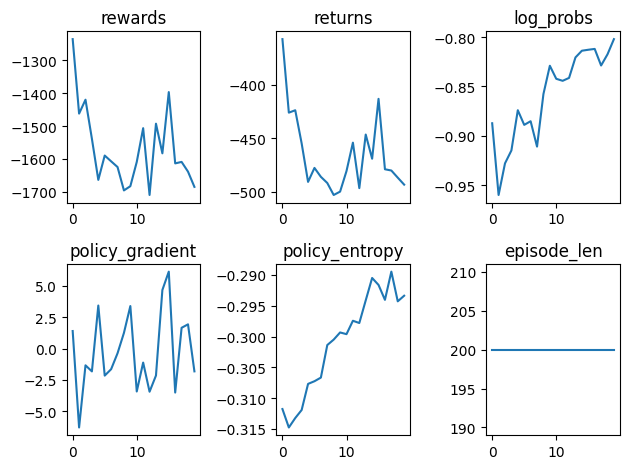

In [19]:
plot_training_results(agent.batch_results)